In [1]:
%matplotlib inline

import pandas
import seaborn
import numpy
import re
import itertools
import time

import matplotlib.pyplot

from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

from Bio import SeqIO

## Dataset

#### SNVs

In [2]:
df = pandas.read_csv("./data/humsavar.txt", sep="\t", header=0)
df.head()

,id,ref,position,mutant,target
0,P04217,H,52,R,POLYMORPHISM
1,P04217,H,395,R,POLYMORPHISM
2,Q9NQ94,V,555,M,POLYMORPHISM
3,Q9NQ94,A,558,S,POLYMORPHISM
4,P01023,R,704,H,POLYMORPHISM


In [3]:
df.shape

(78522, 5)

In [4]:
df['target'].value_counts()

POLYMORPHISM    39448
DISEASE         30877
UNCLASSIFIED     8197
Name: target, dtype: int64

In [5]:
df = df[df['target'].isin([ "POLYMORPHISM", "DISEASE" ])]
df.shape

(70325, 5)

In [6]:
df['target'].value_counts(normalize=True)

POLYMORPHISM    0.560938
DISEASE         0.439062
Name: target, dtype: float64

In [7]:
df[df['target'] == "DISEASE"]['ref'].value_counts(normalize=True)[:5]

R    0.175276
G    0.121093
L    0.074716
A    0.059494
C    0.056612
Name: ref, dtype: float64

In [8]:
df[df['target'] == "POLYMORPHISM"]['ref'].value_counts(normalize=True)[:5]

R    0.130374
A    0.088141
V    0.079522
S    0.075035
T    0.068521
Name: ref, dtype: float64

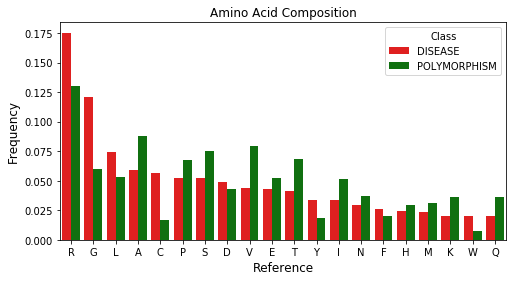

In [9]:
p = df.groupby("target")['ref'].value_counts(normalize=True).reset_index(name='freq')

matplotlib.pyplot.figure(figsize=(8, 4))

seaborn.barplot(x='ref', y= 'freq', data=p, hue='target', palette=["red", "green"])

matplotlib.pyplot.title('Amino Acid Composition')
matplotlib.pyplot.legend(title='Class')
matplotlib.pyplot.ylabel('Frequency', fontsize=12)
matplotlib.pyplot.xlabel('Reference', fontsize=12)
matplotlib.pyplot.show()

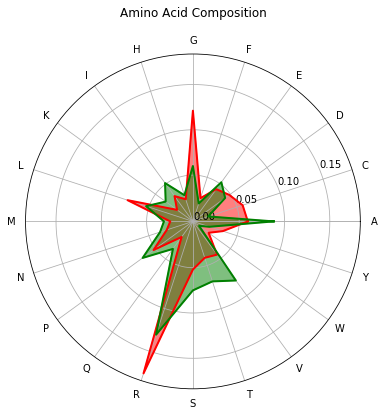

In [10]:
# see: https://typewind.github.io/2017/09/29/radar-chart/

p = df[df['target'] == "DISEASE"]['ref'].value_counts(normalize=True).sort_index()
q = df[df['target'] == "POLYMORPHISM"]['ref'].value_counts(normalize=True).sort_index()

assert list(p.index) == list(q.index)

# show AAs on outer ring
header = p.index

# frequencies and theta for plotting
p = list(p.values)
q = list(q.values)
theta = list(numpy.linspace(0, 2 * numpy.pi, len(header), endpoint=False)) # 2π radians = 360°

# data/theta needs to be "closed"
p.append(p[0])
q.append(q[0])
theta.append(theta[0])


fig = matplotlib.pyplot.figure(figsize=(6, 8))
ax = fig.add_subplot(111, polar=True)

ax.plot(theta, p, '-', linewidth=2, color="red")
ax.fill(theta, p, alpha=0.5, color="red")

ax.plot(theta, q, '-', linewidth=2, color="green")
ax.fill(theta, q, alpha=0.5, color="green")

ax.set_thetagrids(numpy.array(theta) * 180/numpy.pi, header)

ax.set_title("Amino Acid Composition\n")

#ax.grid(False)
#ax.get_yaxis().set_visible(False)
#ax.yaxis.set_ticklabels([ ])
#ax.set_rlim(0,0.2)
matplotlib.pyplot.yticks(numpy.arange(0, 0.2, 0.05));

#### Sequences

In [11]:
UniProt = {}

for record in SeqIO.parse("./data/humsavar.fa", "fasta"):
    _, record.id, _ = record.id.split("|")
    
    if record.id in UniProt:
        raise AssertionError("Duplicate Sequence")
        
    UniProt[record.id] = str(record.seq)

In [12]:
len(UniProt)

12845

In [13]:
len(set(UniProt.values())) # duplicate sequences?!

12841

In [14]:
def fetch_window(id, position, window=10):
    p = max(0, position - (window + 1))
    q = min(position + window, len(str(UniProt[id])))
    
    return str(UniProt[id])[p:position - 1].rjust(window, '-') + \
           str(UniProt[id])[position - 1] + \
           str(UniProt[id])[position:q].ljust(window, "-")

df['window'] = df.apply(lambda x: fetch_window(x['id'], x['position'], 10), axis=1)
df.head()

,id,ref,position,mutant,target,window
0,P04217,H,52,R,POLYMORPHISM,LANVTLTCQAHLETPDFQLFK
1,P04217,H,395,R,POLYMORPHISM,GSAPSERLELHVDGPPPRPQL
2,Q9NQ94,V,555,M,POLYMORPHISM,GYAVPNATAPVSAAQLKQAVT
3,Q9NQ94,A,558,S,POLYMORPHISM,VPNATAPVSAAQLKQAVTLGQ
4,P01023,R,704,H,POLYMORPHISM,QYEMHGPEGLRVGFYESDVMG


In [15]:
set(df['window'].apply(len))

{21}

#### Composition of K-Spaced Amino Acid Pairs

In [16]:
GAP = 7
AA  = "ACDEFGHIKLMNPQRSTVWY"

permutation = [ x[0] + ("." * k) + x[1] for k in range(0, GAP + 1) for x in itertools.product(AA, repeat=2) ]

In [17]:
len(permutation)

3200

In [18]:
(len(AA) ** 2) *(GAP + 1)

3200

In [19]:
def Encoding(seq, normalize=True):
    X = []

    for i in range(0, len(permutation), len(AA) ** 2): # batch processing so we can normalize by gap
        freq = [ len(re.findall("(?={0})".format(p), seq)) for p in permutation[i:i + len(AA) ** 2] ]
        
        if normalize:
            freq = numpy.array(freq) / sum(freq)
            
        X.extend(freq)

    return X
    #return [ len(re.findall("(?={0})".format(p), seq)) for p in permutation ]

In [20]:
[ x for x in zip(permutation, Encoding("AABACACBCA", False)) if x[1] > 0 ]

[('AA', 1),
 ('AC', 2),
 ('CA', 2),
 ('A.A', 2),
 ('C.C', 2),
 ('A..A', 1),
 ('A..C', 3),
 ('C..A', 1),
 ('A...A', 2),
 ('A...C', 1),
 ('C...C', 1),
 ('A....A', 1),
 ('A....C', 2),
 ('C....A', 1),
 ('A.....A', 1),
 ('A.....C', 1),
 ('A......C', 1),
 ('A.......A', 1),
 ('A.......C', 1)]

In [21]:
tqdm.pandas() # now we can use 'progress_apply' instead of 'apply' to see a progress bar!

df['CKSAAP'] = df.progress_apply(lambda x: Encoding(x['window']), axis=1)
df.head()

,id,ref,position,mutant,target,window,CKSAAP
0,P04217,H,52,R,POLYMORPHISM,LANVTLTCQAHLETPDFQLFK,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0,..."
1,P04217,H,395,R,POLYMORPHISM,GSAPSERLELHVDGPPPRPQL,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Q9NQ94,V,555,M,POLYMORPHISM,GYAVPNATAPVSAAQLKQAVT,"[0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Q9NQ94,A,558,S,POLYMORPHISM,VPNATAPVSAAQLKQAVTLGQ,"[0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,P01023,R,704,H,POLYMORPHISM,QYEMHGPEGLRVGFYESDVMG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
# sanity check ...

p = df.iloc[0]

Encoding(p['window']) == p['CKSAAP']

True

## Models

#### Random Forest

In [23]:
X = pandas.DataFrame(list(df['CKSAAP']), columns=permutation)
X.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,Y.......M,Y.......N,Y.......P,Y.......Q,Y.......R,Y.......S,Y.......T,Y.......V,Y.......W,Y.......Y
0,0.00,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X.shape

(70325, 3200)

In [25]:
# remove features with zero variance

X = X.loc[:, X.apply(pandas.Series.nunique) != 1]
X.shape

(70325, 3200)

In [26]:
Y = list(numpy.where(df['target'] == "DISEASE", 1, 0))

In [27]:
skf = StratifiedKFold(10, shuffle=True, random_state=42)

for d in range(5, 80, 5):   
    model = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=42)
    perf = cross_val_score(model, X, numpy.array(Y), scoring="average_precision", cv=skf, n_jobs=-1, verbose=0)
    
    print("max_depth={0}, precision={1:.2f}".format(d, numpy.mean(perf)))
    
    time.sleep(5)

max_depth=5, precision=0.60
max_depth=10, precision=0.66
max_depth=15, precision=0.72
max_depth=20, precision=0.77
max_depth=25, precision=0.80
max_depth=30, precision=0.82
max_depth=35, precision=0.83
max_depth=40, precision=0.84
max_depth=45, precision=0.84
max_depth=50, precision=0.84
max_depth=55, precision=0.85
max_depth=60, precision=0.85
max_depth=65, precision=0.85
max_depth=70, precision=0.85
max_depth=75, precision=0.85


In [28]:
model = RandomForestClassifier(n_estimators=100, max_depth=55, random_state=42) # precision=0.85
model.fit(X, numpy.array(Y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=55, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [29]:
rank = pandas.DataFrame(model.feature_importances_, index=X.columns, columns=[ 'Importance' ])
rank.sort_values(by='Importance', ascending=False, inplace=True)

rank.head(20)

,Importance
S..S,0.002354
G..G,0.002216
G.....G,0.002125
IG,0.002103
S.....P,0.001556
S.S,0.001546
SS,0.001543
S...S,0.001479
P...P,0.001432
IA,0.001314
